In [ ]:
pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.3/148.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.0 MB/s eta 0:00:00


In [ ]:
import fastf1 as ff1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [1]:
def collect_race_data(year, race_round):
    session = ff1.get_session(year, race_round, 'R')
    session.load()

    data = []

    # Loop through laps in the race
    for lap in session.laps.iterlaps():
        lap_time = lap[1]['LapTime'].total_seconds()
        driver = lap[1]['Driver']
        lap_number = lap[1]['LapNumber']

        # Append data
        data.append({
            'Driver': driver,
            'LapTime': lap_time,
            'LapNumber': lap_number,
        })

    return pd.DataFrame(data)

In [ ]:
def prepare_data_for_model(race_data, rolling_window=5, slow_threshold=2, consistency_required=3):
    # Calculate rolling average lap time
    race_data['AvgLapTime'] = race_data.groupby('Driver')['LapTime'].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean())

    # Check for slow laps compared to average
    race_data['SlowLap'] = race_data['LapTime'] < (race_data['AvgLapTime'] - slow_threshold)

    # Create a count of consecutive slow laps
    race_data['ConsecutiveSlows'] = race_data.groupby('Driver')['SlowLap'].transform(lambda x: x.cumsum())

    # Label pit stop if there have been 'consistency_required' consecutive slow laps
    race_data['PitStop'] = (race_data['ConsecutiveSlows'] >= consistency_required).astype(int)

    # Create features and labels
    features = race_data[['LapTime', 'AvgLapTime']]
    labels = race_data['PitStop']

    return features, labels


In [ ]:
def visualize_predictions(race_data):
    plt.figure(figsize=(14, 10))

    # Scatter plot of Lap Time vs. Average Lap Time
    plt.subplot(3, 2, 1)
    sns.scatterplot(data=race_data, x='AvgLapTime', y='LapTime', hue='Driver', style='PitStop', alpha=0.7)
    plt.title('Lap Time vs. Average Lap Time')
    plt.xlabel('Average Lap Time (s)')
    plt.ylabel('Lap Time (s)')
    plt.axhline(race_data['AvgLapTime'].mean(), color='red', linestyle='--', label='Mean Avg Lap Time')
    plt.legend()

    # Line plot of Consecutive Slow Laps
    plt.subplot(3, 2, 2)
    sns.lineplot(data=race_data, x='LapNumber', y='ConsecutiveSlows', hue='Driver', marker='o')
    plt.title('Consecutive Slow Laps Over Time')
    plt.xlabel('Lap Number')
    plt.ylabel('Consecutive Slow Laps')

    # Bar chart of predicted pit stops
    pit_stop_counts = race_data.groupby('Driver')['PitStop'].sum().reset_index()
    plt.subplot(3, 2, 3)
    sns.barplot(data=pit_stop_counts, x='Driver', y='PitStop', palette='viridis')
    plt.title('Predicted Pit Stops per Driver')
    plt.xlabel('Driver')
    plt.ylabel('Predicted Pit Stops')

    # Box plot of Lap Times
    plt.subplot(3, 2, 4)
    sns.boxplot(data=race_data, x='Driver', y='LapTime', palette='Set2')
    plt.title('Lap Time Distribution per Driver')
    plt.xlabel('Driver')
    plt.ylabel('Lap Time (s)')

    plt.tight_layout()
    plt.show()

In [ ]:
race_data = collect_race_data(2023, 5)

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) /root/.cache/fastf1
core           INFO 	Loading data for Miami Grand Prix - Race [v3.4.0]
INFO:fastf1.fastf1.core:Loading data for Miami Grand Prix - Race [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading da

In [ ]:
print(race_data)

     Driver  LapTime  LapNumber
0       VER  101.724        1.0
1       VER   94.260        2.0
2       VER   94.127        3.0
3       VER   92.935        4.0
4       VER   92.875        5.0
...     ...      ...        ...
1133    SAR   92.622       52.0
1134    SAR   94.326       53.0
1135    SAR   93.065       54.0
1136    SAR   93.375       55.0
1137    SAR   94.641       56.0

[1138 rows x 3 columns]


In [ ]:
X, y = prepare_data_for_model(race_data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model: Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy * 100:.2f}%")

Model accuracy: 82.46%


<ipython-input-6-73161badc557>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pit_stop_counts, x='Driver', y='PitStop', palette='viridis')
<ipython-input-6-73161badc557>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=race_data, x='Driver', y='LapTime', palette='Set2')


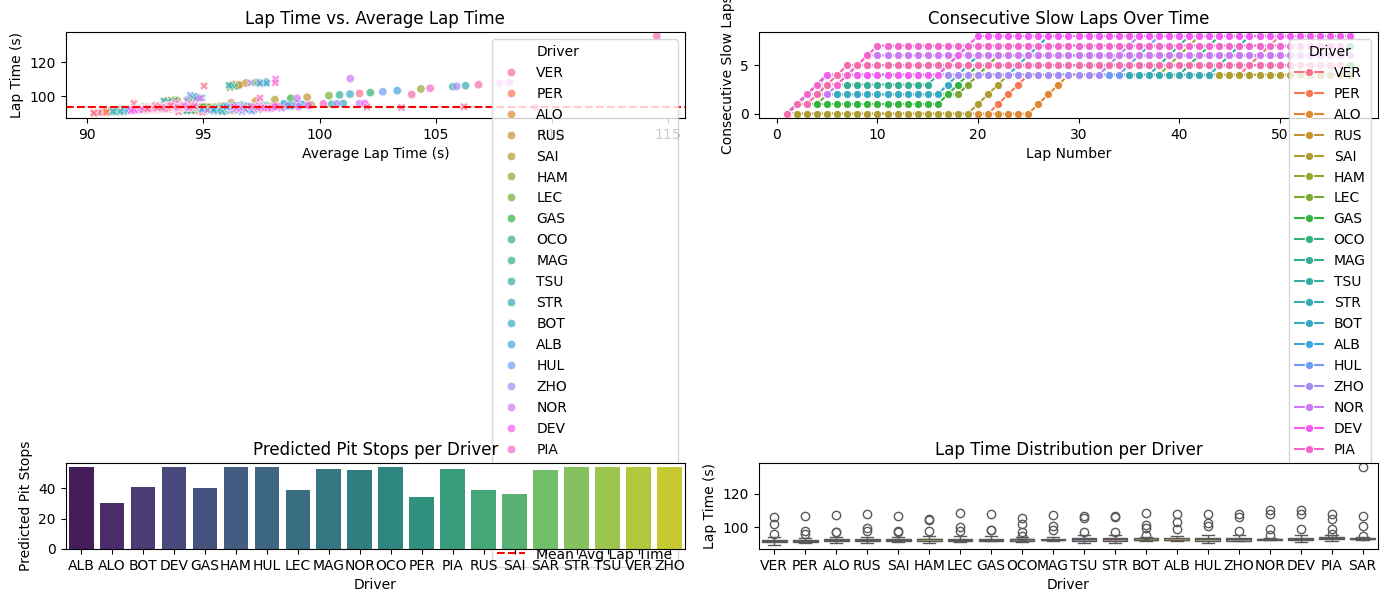

In [ ]:
visualize_predictions(race_data)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

In [ ]:
race_data = collect_race_data(2023, 5)

core           INFO 	Loading data for Miami Grand Prix - Race [v3.4.0]
INFO:fastf1.fastf1.core:Loading data for Miami Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           IN

In [ ]:
X, y = prepare_data_for_model(race_data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(),
}

# Store results
results = {}

In [ ]:
for model_name, model in models.items():
    accuracy, _ = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    results[model_name] = accuracy

In [ ]:
for model_name, accuracy in results.items():
    print(f"{model_name} accuracy: {accuracy * 100:.2f}%")

Random Forest accuracy: 82.46%
Logistic Regression accuracy: 86.40%
Support Vector Classifier accuracy: 87.28%
Gradient Boosting accuracy: 85.09%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.show()

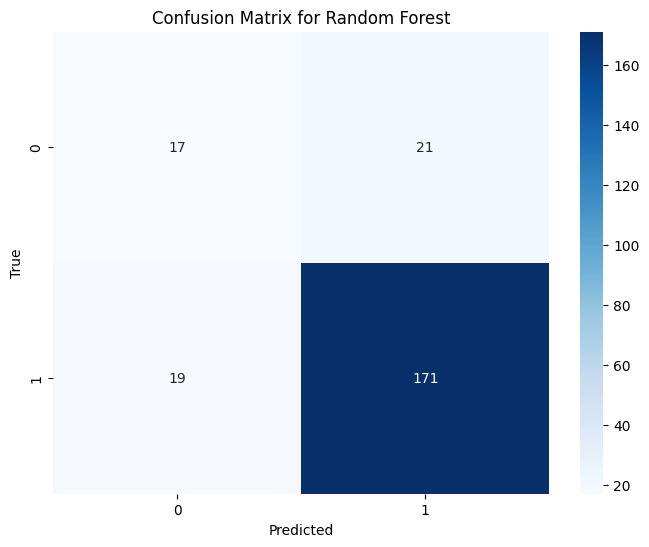

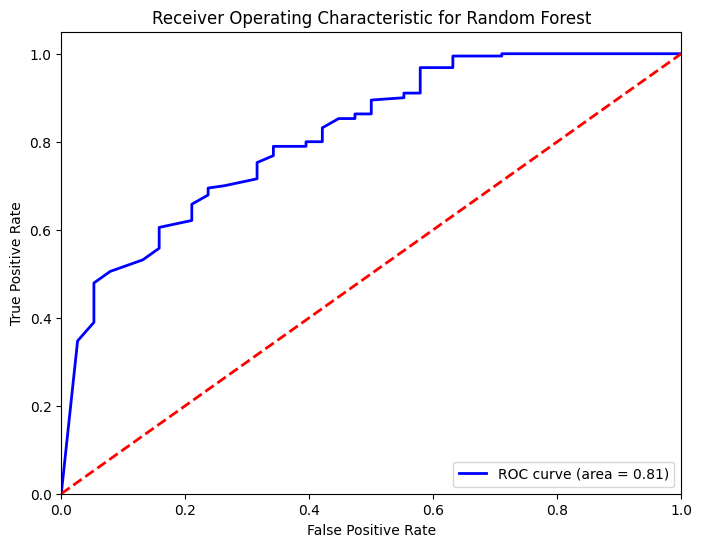

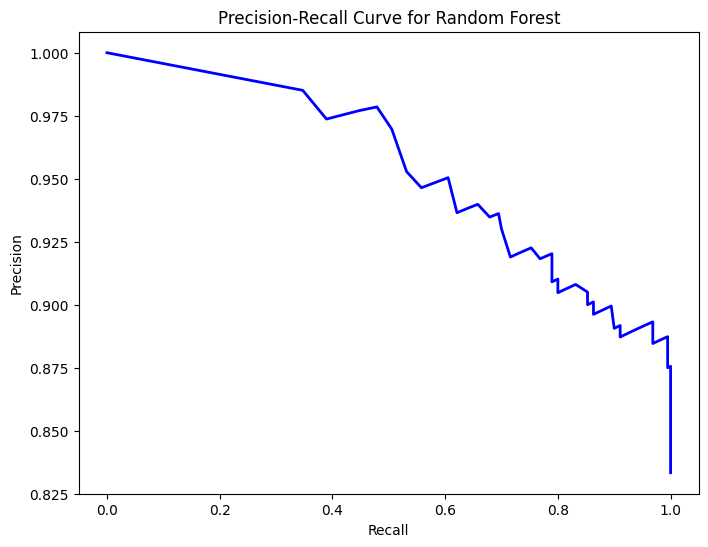

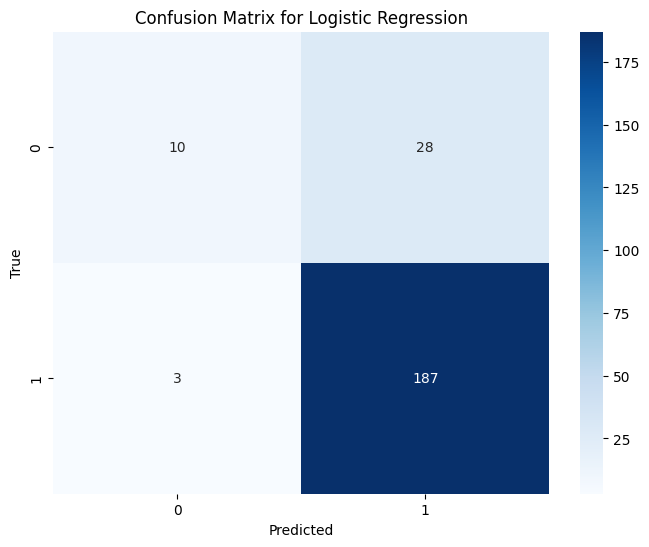

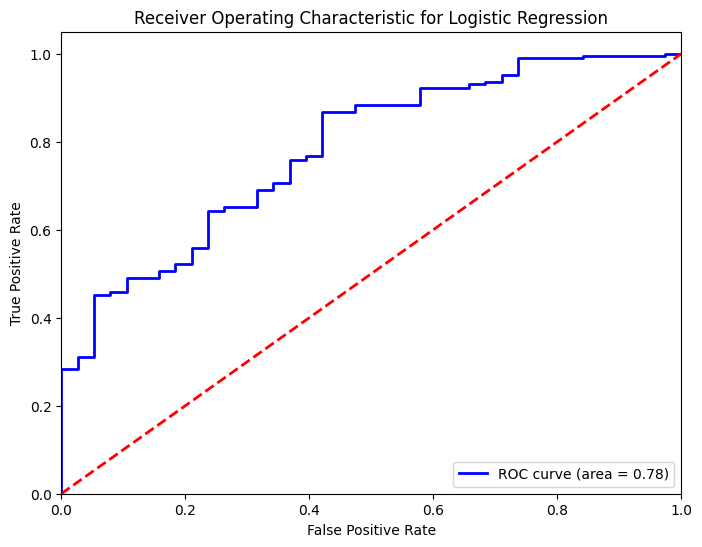

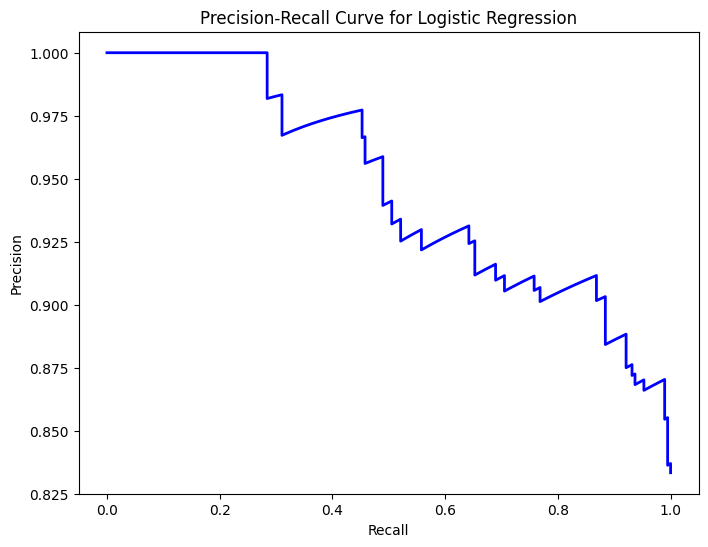

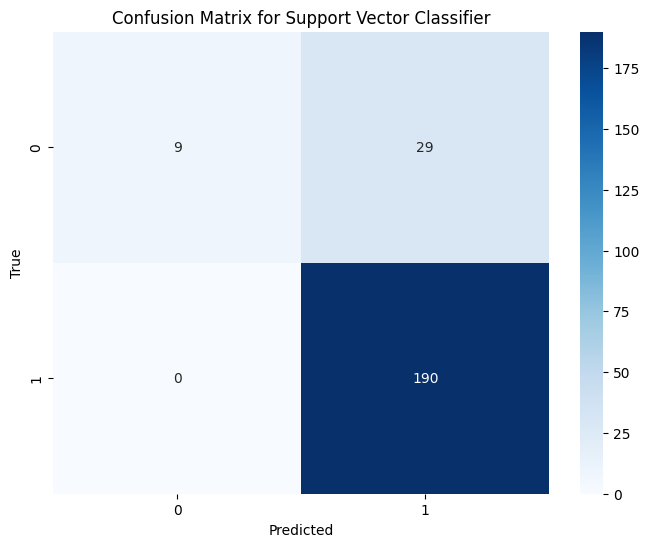

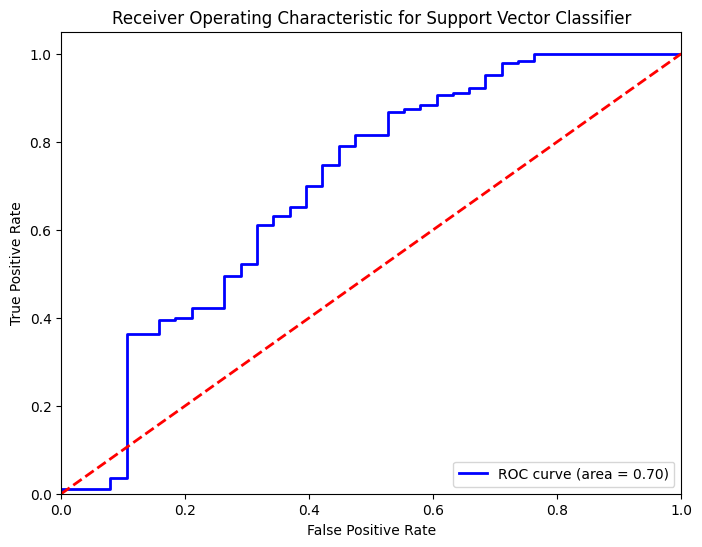

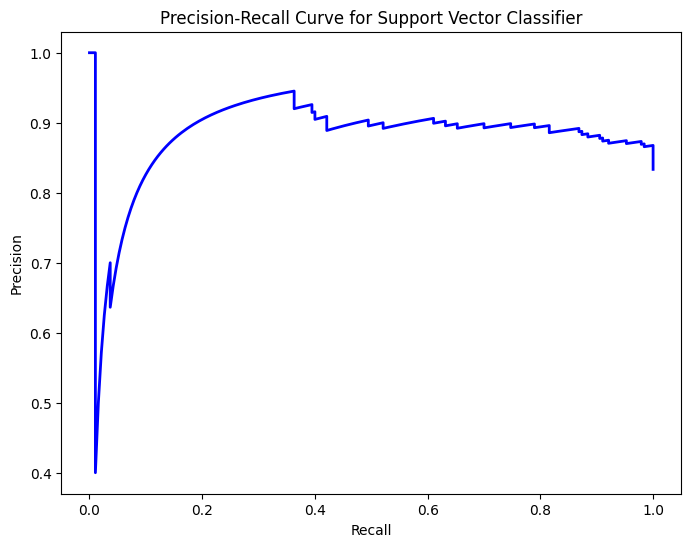

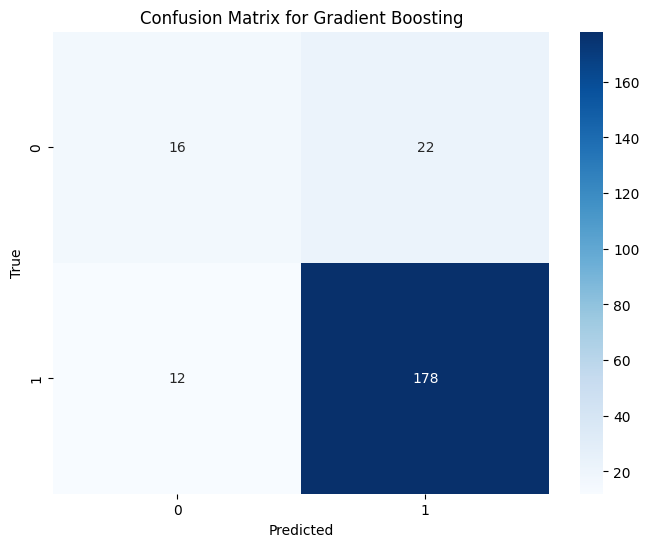

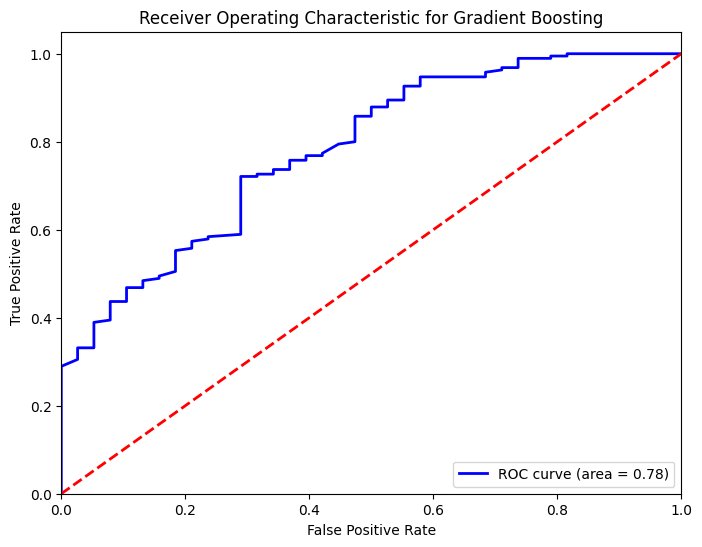

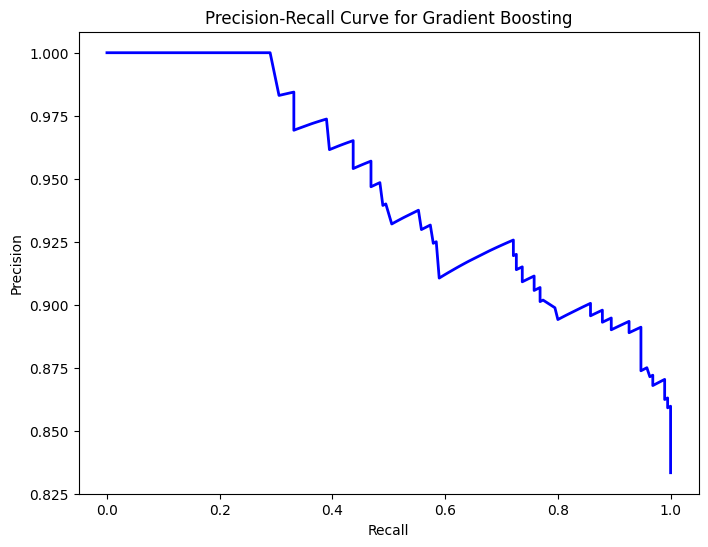

In [ ]:
# Store results and predictions
predictions = {}

for model_name, model in models.items():
    accuracy, y_pred = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    predictions[model_name] = y_pred

    # For probabilistic models
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        plot_confusion_matrix(y_test, y_pred, model_name)
        plot_roc_curve(y_test, y_pred_proba, model_name)
        plot_precision_recall_curve(y_test, y_pred_proba, model_name)
    else:
        plot_confusion_matrix(y_test, y_pred, model_name)

In [ ]:
# Print results
for model_name, accuracy in results.items():
    print(f"{model_name} accuracy: {accuracy * 100:.2f}%")

Random Forest accuracy: 82.46%
Logistic Regression accuracy: 86.40%
Support Vector Classifier accuracy: 87.28%
Gradient Boosting accuracy: 85.09%


core           INFO 	Loading data for Miami Grand Prix - Race [v3.4.0]
INFO:fastf1.fastf1.core:Loading data for Miami Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           IN

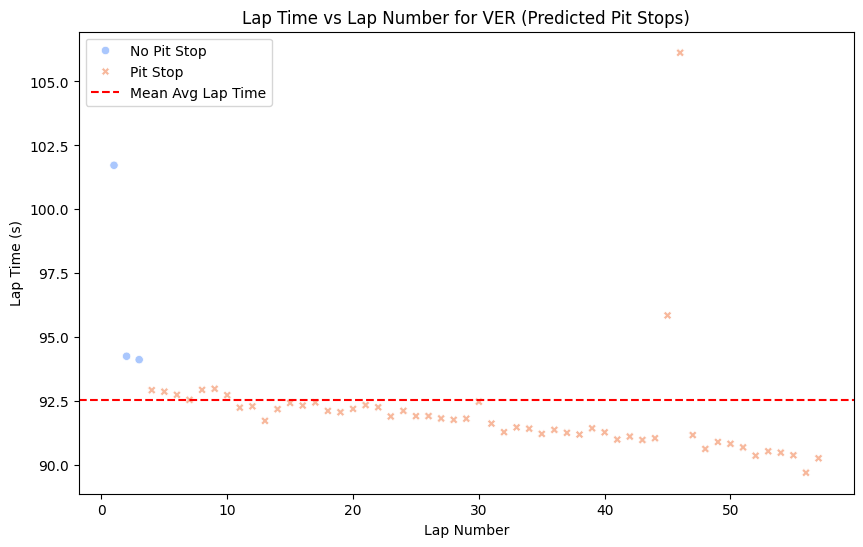

    LapNumber  LapTime PredictedPitStop
0         1.0  101.724      No Pit Stop
1         2.0   94.260      No Pit Stop
2         3.0   94.127      No Pit Stop
3         4.0   92.935         Pit Stop
4         5.0   92.875         Pit Stop
5         6.0   92.753         Pit Stop
6         7.0   92.555         Pit Stop
7         8.0   92.947         Pit Stop
8         9.0   92.988         Pit Stop
9        10.0   92.740         Pit Stop
10       11.0   92.251         Pit Stop
11       12.0   92.304         Pit Stop
12       13.0   91.736         Pit Stop
13       14.0   92.193         Pit Stop
14       15.0   92.433         Pit Stop
15       16.0   92.333         Pit Stop
16       17.0   92.455         Pit Stop
17       18.0   92.124         Pit Stop
18       19.0   92.073         Pit Stop
19       20.0   92.203         Pit Stop
20       21.0   92.351         Pit Stop
21       22.0   92.267         Pit Stop
22       23.0   91.906         Pit Stop
23       24.0   92.126         Pit Stop


In [ ]:
# Define the driver to analyze
driver_to_analyze = 'VER'  # Use a driver's code (e.g., 'VER' for Verstappen)

# Filter the data for the specific driver
def filter_driver_data(race_data, driver):
    return race_data[race_data['Driver'] == driver]

# Collect and prepare data
race_data = collect_race_data(2023, 5)
driver_data = filter_driver_data(race_data, driver_to_analyze)

X, y = prepare_data_for_model(driver_data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training and evaluation
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting on the driver's data
driver_predictions = model.predict(X_test)
driver_data['PredictedPitStop'] = model.predict(X)
driver_data['PredictedPitStop'] = driver_data['PredictedPitStop'].replace({0: 'No Pit Stop', 1: 'Pit Stop'})

# Visualize the predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=driver_data, x='LapNumber', y='LapTime', hue='PredictedPitStop', style='PredictedPitStop', palette='coolwarm')
plt.axhline(driver_data['AvgLapTime'].mean(), color='red', linestyle='--', label='Mean Avg Lap Time')
plt.title(f'Lap Time vs Lap Number for {driver_to_analyze} (Predicted Pit Stops)')
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (s)')
plt.legend()
plt.show()

# Display pit stop predictions
print(driver_data[['LapNumber', 'LapTime', 'PredictedPitStop']])
